In [2]:
import os
import sys
import re
import time 
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from generation_utils import *
import itertools
from scipy.stats import spearmanr, wasserstein_distance
if '..' not in sys.path: sys.path.insert(0, '..')
# from encore.model import Decoder, Sequential
from utils.initialization import *
from utils.distribution_utils import *
from utils.eval import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
os.chdir(sys.path[0])
size_dir = './data/size/'
interval_dir = './data/interval/'
metadata_dir = './data/metadata/'
size_cdf = pd.read_csv('./data/cdf/size_cdf.csv')
interval_cdf = pd.read_csv('./data/cdf/interval_cdf.csv')
n_size = len(size_cdf) - 1
n_interval = len(interval_cdf) - 1
files = os.listdir(size_dir)
block_size = 30

file = 'app_182.txt'
app = file.strip('.txt')
data = get_data(size_dir, interval_dir, file, n_interval)

In [4]:
def calculate_base_fct(flow_size, base_rtt=0.044, pkt_size=512, initial_cwnd=10, bw=200e6):
    bdp = base_rtt * bw / 8
    base_fct = (np.log2(np.minimum(flow_size, bdp) / (initial_cwnd * pkt_size) + 1) + ((flow_size - np.minimum(flow_size, bdp)) * 8) / bw + 1) * base_rtt
    return base_fct

In [5]:
fct_dir = './simulation/data/result/fct'
drop_dir = './simulation/data/result/drop'
tp_dir = './simulation/data/result/tp'
qlen_dir = './simulation/data/result/qlen'

traces = ['common_app_182', 'lomas_app_182', 'encore_app_182', 'real_app_182']
labels = ['Common Practice', 'Lomas', 'Encore', 'Ground Truth']
colors = ['SlateGray', 'IndianRed', 'CornFlowerBlue', 'DarkGoldenRod', 'LimeGreen', 'LightSeaGreen', 'Purple']
linestyles = ['-.', '--', '-.', '--', '-.']

config = '100_1000_0.1'
files = []
for trace in traces:
    files.append(f'{trace}_{config}.csv')

fcts, drops, tps, qlens = {}, {}, {}, {}
leafSlowdown = {}

for file in files:
    fcts[file] = pd.read_csv(os.path.join(fct_dir, file))
    drops[file] = pd.read_csv(os.path.join(drop_dir, file))
    tps[file] = pd.read_csv(os.path.join(tp_dir, file))
    qlens[file] = pd.read_csv(os.path.join(qlen_dir, file))
    fcts[file]['base_fct'] = fcts[file]['Size'].apply(calculate_base_fct)
    fcts[file]['slowdown'] = (fcts[file]['CompletionTime'] / fcts[file]['base_fct']).clip(lower=1)
    leafSlowdown[file] = fcts[file].groupby('Leaf')['slowdown'].mean()
    drops[file]['DropRate'] = drops[file]['DropPacket'] / drops[file]['TotalPacket']
    print(file, config, drops[file]['DropRate'].mean(), drops[file]['DropRate'].std())

common_app_182_100_1000_0.1.csv 100_1000_0.1 0.0005657391027558676 0.0010946848585544997
lomas_app_182_100_1000_0.1.csv 100_1000_0.1 0.0008326229960535899 0.0010346226725308784
encore_app_182_100_1000_0.1.csv 100_1000_0.1 0.015665216133115938 0.008658809298693813
real_app_182_100_1000_0.1.csv 100_1000_0.1 0.014450142008051078 0.007907311752887813


In [6]:
fig = plt.figure(figsize=(4, 3))
plt.subplots_adjust(left=0.2, top=0.99, bottom=0.2, right=0.99)
ax = plt.subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('CDF', fontsize=16)
ax.set_xlabel(f'FCT Slowdown (log10)', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='-.')
for i, file in enumerate(files):
    plot_cdf(np.log10(fcts[file]['slowdown'].values), label=labels[i], color=colors[i], linestyle=linestyles[i])
plt.legend(fontsize=14, frameon=False, loc=(0.27, 0), labelspacing=0.25,handlelength=2.05, handletextpad=0.5)
plt.savefig('./figures/evaluation/evaluation_all_fct.pdf', dpi=400)
plt.close()

In [7]:
fig = plt.figure(figsize=(4, 3))
plt.subplots_adjust(left=0.2, top=0.99, bottom=0.2, right=0.99)
ax = plt.subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('CDF', fontsize=16)
ax.set_xlabel('FCT Slowdown', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='-.')
for i, file in enumerate(files):
    plot_cdf(leafSlowdown[file].values, label=labels[i], color=colors[i], linestyle=linestyles[i])
plt.legend(fontsize=14, frameon=False, loc=(0.27, 0), labelspacing=0.25,handlelength=2.05, handletextpad=0.5)
plt.savefig('./figures/evaluation/evaluation_per_leaf_fct.pdf', dpi=400)
plt.close()

In [8]:
fig = plt.figure(figsize=(4, 3))
plt.subplots_adjust(left=0.2, top=0.99, bottom=0.2, right=0.99)
ax = plt.subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('CDF', fontsize=16)
ax.set_xlabel('Throughput', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='-.')
for i, file in enumerate(files):
    tp = tps[file]['Throughput'][0:120].values * 8 / 200e6
    plot_cdf(tp, label=labels[i], color=colors[i], linestyle=linestyles[i])
plt.legend(fontsize=14, frameon=False, loc=(0.27, 0), labelspacing=0.25,handlelength=2.05, handletextpad=0.5)
plt.savefig('./figures/evaluation/evaluation_throughput.pdf', dpi=400)
plt.close()

In [9]:
fig = plt.figure(figsize=(4, 3))
plt.subplots_adjust(left=0.2, top=0.99, bottom=0.2, right=0.99)
ax = plt.subplot(111)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('CDF', fontsize=16)
ax.set_xlabel('Queue Length (KB)', fontsize=16)
plt.ylim(0.6, 1.05)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(linestyle='-.')
for i, file in enumerate(files):
    qlen = qlens[file]['QueueLength'][0:120].values / 1000
    plot_cdf(qlen, label=labels[i], color=colors[i], linestyle=linestyles[i])
plt.legend(fontsize=16, frameon=False, loc=(0.15, 0), labelspacing=0.25,handlelength=2.05, handletextpad=0.5)
plt.savefig('./figures/evaluation/evaluation_queue_length.pdf', dpi=400)
plt.close()

In [10]:
print(wasserstein_distance(fcts[files[0]]['slowdown'].values, fcts[files[3]]['slowdown'].values), wasserstein_distance(fcts[files[1]]['slowdown'].values, fcts[files[3]]['slowdown'].values), wasserstein_distance(fcts[files[2]]['slowdown'].values, fcts[files[3]]['slowdown'].values))
print(wasserstein_distance(leafSlowdown[files[0]].values, leafSlowdown[files[3]].values), wasserstein_distance(leafSlowdown[files[1]].values, leafSlowdown[files[3]].values), wasserstein_distance(leafSlowdown[files[2]].values, leafSlowdown[files[3]].values))
print(wasserstein_distance(tps[files[0]]['Throughput'][0:120].values * 8 / 200e6, tps[files[3]]['Throughput'][0:120].values * 8 / 200e6), wasserstein_distance(tps[files[1]]['Throughput'][0:120].values * 8 / 200e6, tps[files[3]]['Throughput'][0:120].values * 8 / 200e6), wasserstein_distance(tps[files[2]]['Throughput'][0:120].values * 8 / 200e6, tps[files[3]]['Throughput'][0:120].values * 8 / 200e6))
print(wasserstein_distance(qlens[files[0]]['QueueLength'][0:120].values / 1000, qlens[files[3]]['QueueLength'][0:120].values / 1000), wasserstein_distance(qlens[files[1]]['QueueLength'][0:120].values / 1000, qlens[files[3]]['QueueLength'][0:120].values / 1000), wasserstein_distance(qlens[files[2]]['QueueLength'][0:120].values / 1000, qlens[files[3]]['QueueLength'][0:120].values / 1000))

print(wasserstein_distance(fcts[files[0]]['slowdown'].values, fcts[files[3]]['slowdown'].values) / wasserstein_distance(fcts[files[2]]['slowdown'].values, fcts[files[3]]['slowdown'].values))
print(wasserstein_distance(leafSlowdown[files[0]].values, leafSlowdown[files[3]].values) / wasserstein_distance(leafSlowdown[files[2]].values, leafSlowdown[files[3]].values))
print(wasserstein_distance(tps[files[0]]['Throughput'][0:120].values * 8 / 200e6, tps[files[3]]['Throughput'][0:120].values * 8 / 200e6) / wasserstein_distance(tps[files[2]]['Throughput'][0:120].values * 8 / 200e6, tps[files[3]]['Throughput'][0:120].values * 8 / 200e6))
print(wasserstein_distance(qlens[files[0]]['QueueLength'][0:120].values / 1000, qlens[files[3]]['QueueLength'][0:120].values / 1000) / wasserstein_distance(qlens[files[2]]['QueueLength'][0:120].values / 1000, qlens[files[3]]['QueueLength'][0:120].values / 1000))

2.4693605213904832 2.430097765441239 0.1403087528716003
2.454965908218725 2.4135409380689135 0.14944300287072912
0.140685902 0.14255241 0.03346584066666666
41.630556874666674 40.38713979175001 5.650780541499995
17.59947594752161
16.427439632903486
4.203865768718874
7.367222380859951


In [11]:
fct_dir = './simulation/data/result/fct'
drop_dir = './simulation/data/result/drop'
tp_dir = './simulation/data/result/tp'
qlen_dir = './simulation/data/result/qlen'

min_ths = [5, 10, 20, 50, 100, 200, 500, 1000]
max_ths = [50, 100, 200, 500, 1000, 1500, 2000, 4000]
p_maxs = [0.01, 0.05, 0.1, 0.2]
traces = ['real_app_182', 'common_app_182', 'lomas_app_182', 'encore_app_182']

configs = []
slowdown = {trace:[] for trace in traces}
for i, (min_th, max_th, p_max) in enumerate(itertools.product(min_ths, max_ths, p_maxs)):
    if min_th >= max_th:
        continue
    config = f'{min_th}_{max_th}_{p_max}'
    configs.append(config)
    for trace in traces:
        file = f'{trace}_{config}.csv'
        fct = pd.read_csv(os.path.join(fct_dir, file))
        fct['base_fct'] = fct['Size'].apply(calculate_base_fct)
        fct['slowdown'] = (fct['CompletionTime'] / fct['base_fct']).clip(lower=1)
        slowdown[trace].append(fct['slowdown'].mean())

spearmanr(slowdown[traces[0]], slowdown[traces[1]]), spearmanr(slowdown[traces[0]], slowdown[traces[2]]), spearmanr(slowdown[traces[0]], slowdown[traces[3]])

(SignificanceResult(statistic=-0.010024783048713433, pvalue=0.8890923845476648),
 SignificanceResult(statistic=0.5433862729004136, pvalue=1.8859129955262435e-16),
 SignificanceResult(statistic=0.8778665859158972, pvalue=6.050893711410898e-64))

([<matplotlib.axis.YTick at 0x7f04d44e9bd0>,
 [Text(0, 0, '0'),
  Text(0, 1, '1'),
  Text(0, 2, '2'),
  Text(0, 3, '3'),
  Text(0, 4, '4')])

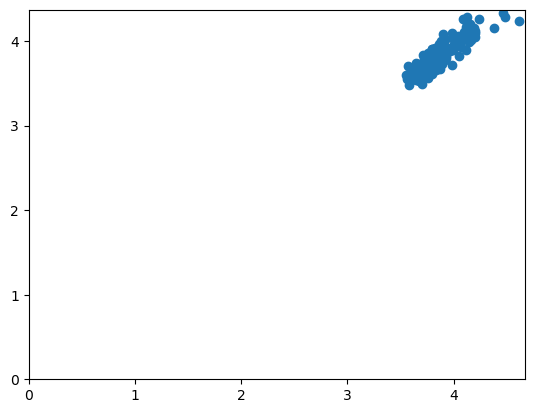

In [12]:
# x = slowdown[traces[0]]
# y = slowdown[traces[2]]
# plt.scatter(x, y)
x = slowdown[traces[0]]
y = slowdown[traces[3]]
plt.scatter(x, y)
plt.xticks(np.arange(0, 5, 1))
plt.yticks(np.arange(0, 5, 1))